In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd 
import statsmodels.formula.api as smf 
import statsmodels.api as sm 
from sklearn.model_selection import train_test_split 
import itertools
%matplotlib inline
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR, LinearSVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import SGDRegressor
from sklearn.metrics import mean_absolute_error #MAE
from sklearn.metrics import mean_squared_error #MSE
from sklearn.metrics import make_scorer
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import time
import hdbscan
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import matplotlib as mpl
import sklearn.cluster as cluster
from scipy.spatial.distance import cdist

%matplotlib inline
sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()

plot_kwds={'alpha':0.25, 's':60, 'linewidths':0}
palette = sns.color_palette('deep', 12)


# Feature Engineering

## Segment clustering

To combine the close segments together and create several models

In [205]:
df_clean = pd.read_csv('../../01_Outputs/df_clean.csv')

In [206]:
df_clean['SPEC_length_x_width'] = df_clean['SPEC_overall_length_mm'] * df_clean['SPEC_overall_width_mm']
df_clean['SPEC_MYMakeModel'] = df_clean['PROFILE_Model_year'].astype(str) + '_' + df_clean['PROFILE_Make'] + '_' + df_clean['PROFILE_Model']
df_temp = df_clean[['SPEC_MYMakeModel','PROFILE_Model_year','PROFILE_Make','PROFILE_Model','SPEC_length_x_width','TARGET_Volume','TARGET_Weighted_RetailPrice', 'Segment_Name']]
df_temp['Volume_x_price'] = df_temp['TARGET_Volume'] * df_temp['TARGET_Weighted_RetailPrice']
df_temp['Volume_byMYModel'] = df_temp.groupby('SPEC_MYMakeModel')['TARGET_Volume'].transform('sum')
df_temp['Volume_index'] = df_temp['Volume_x_price'] / df_temp['Volume_byMYModel']
df_temp['MSRP_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

In [207]:
df_featureeng = df_temp.groupby(['Segment_Name','PROFILE_Model_year',\
                                 'PROFILE_Make','PROFILE_Model','SPEC_MYMakeModel'])\
[['MSRP_WeightedByVol', 'SPEC_length_x_width']].mean().reset_index()

df_featureeng['SPEC_length_x_width'] = df_featureeng.groupby(['Segment_Name'])['SPEC_length_x_width'].transform(lambda x: x.fillna(x.mean()))

In [175]:
df_featureeng

,Segment_Name,PROFILE_Model_year,PROFILE_Make,PROFILE_Model,SPEC_MYMakeModel,MSRP_WeightedByVol,SPEC_length_x_width
0,COMPACT,2014,HONDA,CIVIC,2014_HONDA_CIVIC,20269.636737,7.970161e+06
1,COMPACT,2014,MAZDA,MAZDA3,2014_MAZDA_MAZDA3,21558.099113,8.135880e+06
2,COMPACT,2014,NISSAN,SENTRA,2014_NISSAN_SENTRA,18035.947784,8.142766e+06
3,COMPACT,2014,SUBARU,IMPREZA,2014_SUBARU_IMPREZA,22291.036758,7.915844e+06
4,COMPACT,2014,TOYOTA,COROLLA,2014_TOYOTA_COROLLA,18963.596095,8.232450e+06
...,...,...,...,...,...,...,...
1195,UPPER MIDSIZE,2022,ACURA,TLX,2022_ACURA_TLX,46524.764330,9.441130e+06
1196,UPPER MIDSIZE,2022,NISSAN,MAXIMA,2022_NISSAN_MAXIMA,40115.117644,9.103523e+06
1197,UPPER MIDSIZE,2022,TOYOTA,AVALON,2022_TOYOTA_AVALON,40033.439171,9.200624e+06
1198,UPPER MIDSIZE,2023,ACURA,TLX,2023_ACURA_TLX,49986.888240,9.441130e+06


In [208]:
scaler = StandardScaler()
df_featureeng['MSRP_WeightedByVol_std'] = scaler.fit_transform(df_featureeng[['MSRP_WeightedByVol']])
df_featureeng['SPEC_length_x_width_std'] = scaler.fit_transform(df_featureeng[['SPEC_length_x_width']])

In [209]:
data = df_featureeng[['MSRP_WeightedByVol_std', 'SPEC_length_x_width_std']].values

In [178]:
data

array([[-0.99586514, -0.91588692],
       [-0.93517124, -0.79863452],
       [-1.10108458, -0.79376263],
       ...,
       [-0.06487772, -0.04529017],
       [ 0.4039863 ,  0.1248764 ],
       [ 0.08637857, -0.11399259]])

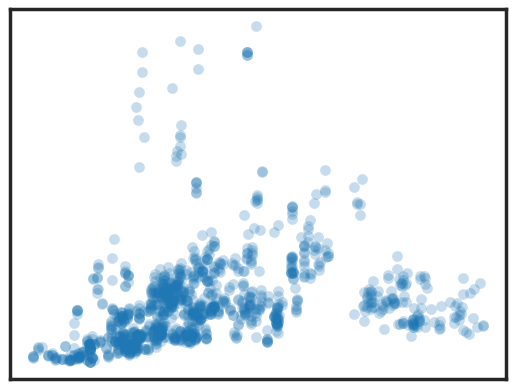

In [210]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.scatter(data.T[1], data.T[0], **plot_kwds)
ax.set_xticks([])
ax.set_yticks([]);

In [180]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(True)
    frame.axes.get_yaxis().set_visible(True)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=12)
    plt.text(-1.0, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=12)

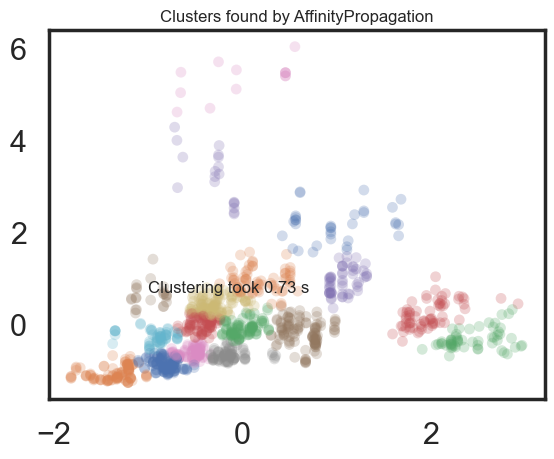

In [211]:
plot_clusters(data, cluster.AffinityPropagation, (), {'preference':-5.0, 'damping':0.95})

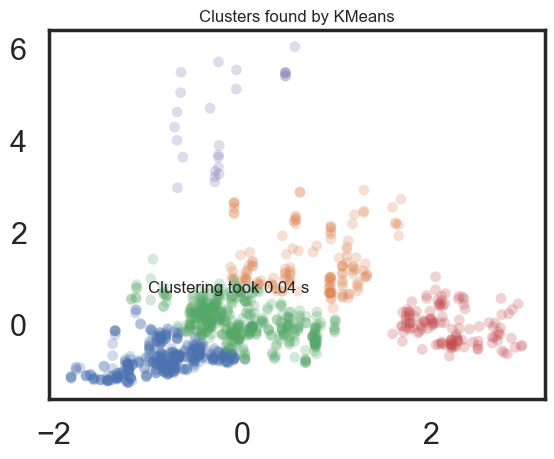

In [212]:
plot_clusters(data, cluster.KMeans, (), {'n_clusters':5})

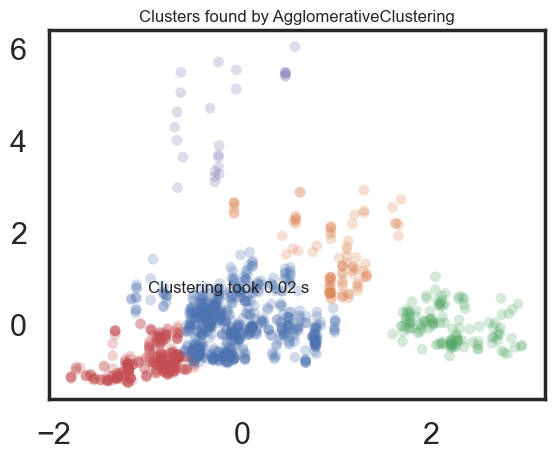

In [213]:
plot_clusters(data, cluster.AgglomerativeClustering, (), {'n_clusters':5, 'linkage':'ward'})

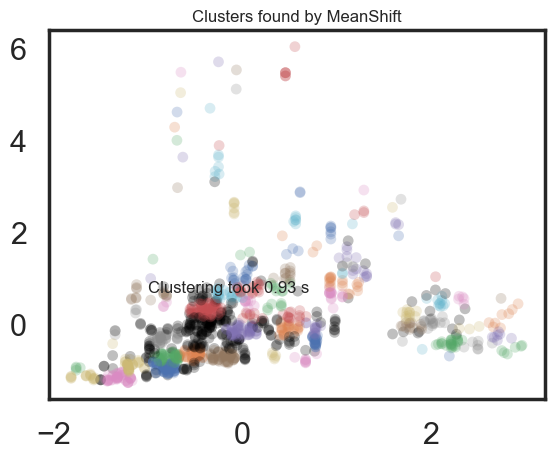

In [214]:
plot_clusters(data, cluster.MeanShift, (), {'cluster_all': False, 'bandwidth': 0.175})

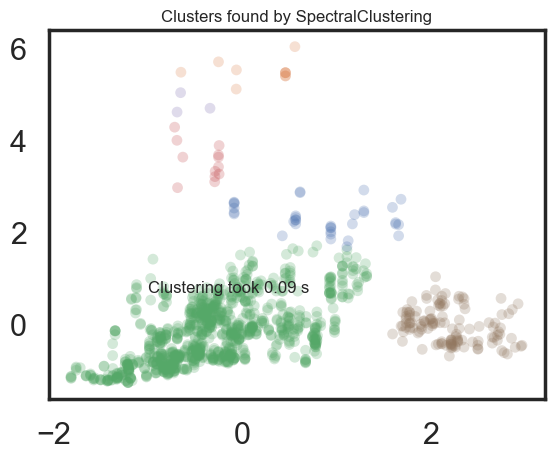

In [215]:
plot_clusters(data, cluster.SpectralClustering, (), {'n_clusters':6})

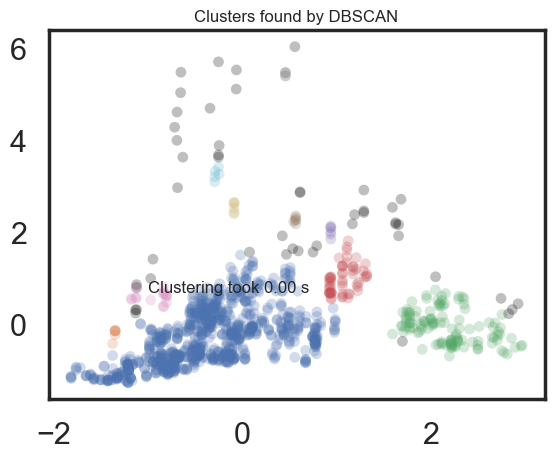

In [216]:
plot_clusters(data, cluster.DBSCAN, (), {'eps':0.2})

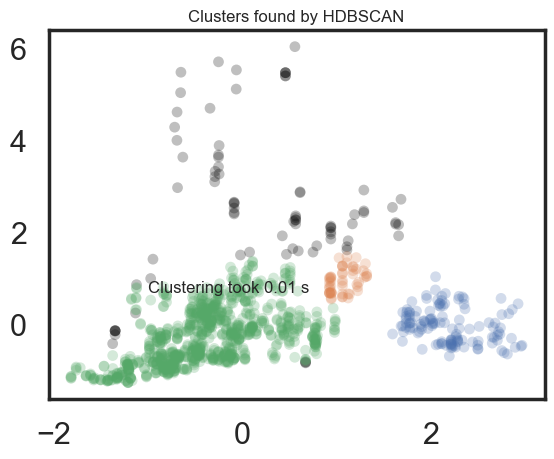

In [217]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':10})

In [218]:
labels= cluster.KMeans(n_clusters=5).fit_predict(data)

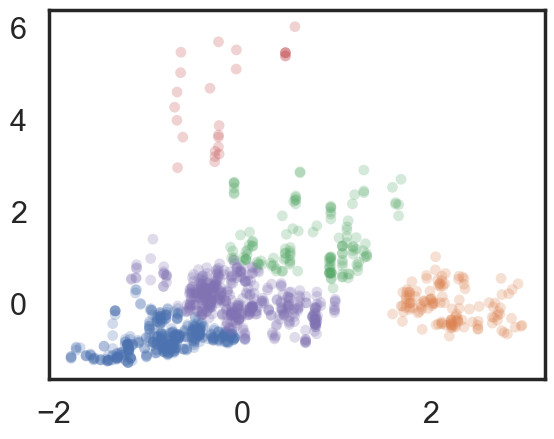

In [219]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(True)

In [220]:
df_featureeng['label'] = labels

'MSRP_WeightedByVol', 'SPEC_length_x_width'

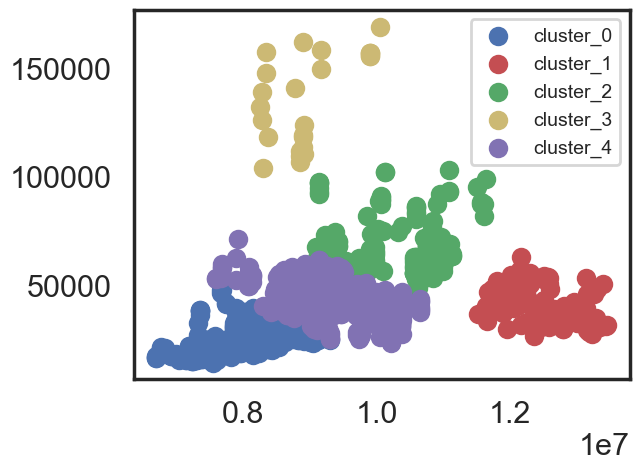

In [221]:
plt.scatter(df_featureeng[df_featureeng['label']==0]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==0]['MSRP_WeightedByVol'],c='b', label='cluster_0')
plt.scatter(df_featureeng[df_featureeng['label']==1]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==1]['MSRP_WeightedByVol'],c='r', label='cluster_1')
plt.scatter(df_featureeng[df_featureeng['label']==2]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==2]['MSRP_WeightedByVol'],c='g', label='cluster_2')
plt.scatter(df_featureeng[df_featureeng['label']==3]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==3]['MSRP_WeightedByVol'],c='y', label='cluster_3')
plt.scatter(df_featureeng[df_featureeng['label']==4]['SPEC_length_x_width'],\
                df_featureeng[df_featureeng['label']==4]['MSRP_WeightedByVol'],c='m', label='cluster_4')
plt.legend(loc="upper right", fontsize=14) # (7)凡例表示

In [ ]:
palette = sns.color_palette('deep', np.unique(labels).max() + 1)
plt.scatter(data.T[1], data.T[0], c=colors, **plot_kwds)
frame = plt.gca()
frame.axes.get_xaxis().set_visible(True)

In [222]:
df_featureeng['cluster'] = labels

In [223]:
cluster_count = df_featureeng.groupby(['Segment_Name', 'cluster'])[['SPEC_MYMakeModel']].count()

In [224]:
cluster_count = cluster_count.reset_index()

In [225]:
cluster_count

,Segment_Name,cluster,SPEC_MYMakeModel
0,COMPACT,0,54
1,COMPACT EV,0,69
2,COMPACT EV,4,5
3,COMPACT LCV VAN,0,20
4,COMPACT LCV VAN,4,7
5,COMPACT SUV,0,33
6,D Coupe,4,35
7,ENTRY,0,60
8,ENTRY SUV,0,33
9,FULLSIZE LCV VAN,1,65


In [227]:
max_rows = cluster_count.groupby('Segment_Name')[['cluster',	'SPEC_MYMakeModel']].apply(lambda x: x.loc[x['SPEC_MYMakeModel'].idxmax()])

In [228]:
max_rows

,cluster,SPEC_MYMakeModel
Segment_Name,,
COMPACT,0,54
COMPACT EV,0,69
COMPACT LCV VAN,0,20
COMPACT SUV,0,33
D Coupe,4,35
ENTRY,0,60
ENTRY SUV,0,33
FULLSIZE LCV VAN,1,65
FULLSIZE PICKUP,1,62


In [231]:
max_rows['cluster'] = max_rows['cluster'].astype(str).replace('0', 'LowPrice_Smallsize').replace('1', 'MidPrice_Largesize').replace('4','MidPrice_Midsize').replace('2','HighPrice')

In [232]:
max_rows.groupby(['cluster']).sum()

,SPEC_MYMakeModel
cluster,
HighPrice,112
LowPrice_Smallsize,393
MidPrice_Largesize,127
MidPrice_Midsize,429


In [233]:
category_table = max_rows.reset_index().rename(columns={'cluster':'CATEGORY'})[['Segment_Name', 'CATEGORY']]

In [ ]:
# category_table.to_csv('Segment_CategoryTable.csv', index=False)

In [234]:
category_table

,Segment_Name,CATEGORY
0,COMPACT,LowPrice_Smallsize
1,COMPACT EV,LowPrice_Smallsize
2,COMPACT LCV VAN,LowPrice_Smallsize
3,COMPACT SUV,LowPrice_Smallsize
4,D Coupe,MidPrice_Midsize
5,ENTRY,LowPrice_Smallsize
6,ENTRY SUV,LowPrice_Smallsize
7,FULLSIZE LCV VAN,MidPrice_Largesize
8,FULLSIZE PICKUP,MidPrice_Largesize
9,FULLSIZE SUV,HighPrice


Drop SPORTS/PERFORMANCE because NISSAN GTR is cluster 4 which can be outlier from the above

In [235]:
df_clean = df_clean[~(df_clean['Segment_Name']=='SPORTS/PERFORMANCE')]

Combine two table and get the Category

In [236]:
df_clean = pd.merge(df_clean, category_table, on='Segment_Name', how='left')

In [237]:
df_clean.groupby('CATEGORY')['TARGET_Weighted_RetailPrice'].count()

CATEGORY
HighPrice              985
LowPrice_Smallsize    3492
MidPrice_Largesize    3841
MidPrice_Midsize      4556
Name: TARGET_Weighted_RetailPrice, dtype: int64

In [238]:
# df_clean.to_csv('backup_df_clean_segment.csv', index=False)

In [3]:
df_clean = pd.read_csv('backup_df_clean_segment.csv')

In [4]:
df_clean = df_clean[df_clean['SPEC_Enginetype_BEV']!=1]

## Create new variables

### Previous year MSRP/RV weighted average

In [239]:
df_clean.filter(like='RV')

,RV_12mo,RV_24mo,RV_36mo,RV_48mo,RV_60mo
0,75.000000,63.250000,55.583333,45.750000,37.166667
1,74.916667,63.333333,56.166667,45.833333,37.333333
2,65.077165,54.206970,45.749871,38.480615,31.291198
3,73.250000,61.083333,53.583333,44.083333,35.916667
4,65.077165,54.206970,45.749871,38.480615,31.291198
...,...,...,...,...,...
12869,70.000000,53.000000,42.000000,31.000000,24.000000
12870,70.000000,54.000000,42.000000,32.000000,24.000000
12871,70.000000,53.000000,42.000000,31.000000,24.000000
12872,70.000000,53.000000,42.000000,31.000000,24.000000


In [5]:
df_temp = df_clean[['SPEC_MYMakeModel','PROFILE_Model_year','PROFILE_Make','PROFILE_Model','TARGET_Volume','TARGET_Weighted_RetailPrice', 'RV_12mo','RV_36mo', 'RV_60mo']]
df_temp['Volume_x_price'] = df_temp['TARGET_Volume'] * df_temp['TARGET_Weighted_RetailPrice']
df_temp['Volume_byMYModel'] = df_temp.groupby('SPEC_MYMakeModel')['TARGET_Volume'].transform('sum')
df_temp['Volume_index'] = df_temp['Volume_x_price'] / df_temp['Volume_byMYModel']
df_temp['MSRP_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_12mo'] = df_temp['TARGET_Volume'] * df_temp['RV_12mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_12mo'] / df_temp['Volume_byMYModel']
df_temp['RV_12mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_36mo'] = df_temp['TARGET_Volume'] * df_temp['RV_36mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_36mo'] / df_temp['Volume_byMYModel']
df_temp['RV_36mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

df_temp['Volume_x_RV_60mo'] = df_temp['TARGET_Volume'] * df_temp['RV_60mo']
df_temp['Volume_index'] = df_temp['Volume_x_RV_60mo'] / df_temp['Volume_byMYModel']
df_temp['RV_60mo_WeightedByVol'] = df_temp.groupby('SPEC_MYMakeModel')['Volume_index'].transform('sum')

In [6]:
df_featureeng = df_temp.groupby(['PROFILE_Model_year',\
                                 'PROFILE_Make','PROFILE_Model','SPEC_MYMakeModel'])\
[['MSRP_WeightedByVol', 'RV_12mo_WeightedByVol', 'RV_36mo_WeightedByVol', 'RV_60mo_WeightedByVol']].mean().reset_index()

In [7]:
df_featureeng = df_featureeng.sort_values(by=['PROFILE_Model', 'PROFILE_Model_year'], ascending=[1,1]).reset_index()

Filling out the values with previous year's values

In [8]:
grouped = df_featureeng.groupby('PROFILE_Model')
df_featureeng['MSRP_prevMY_WeightedByVol'] = grouped['MSRP_WeightedByVol'].shift(1)
df_featureeng['MSRP_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['MSRP_WeightedByVol'] \
                        if pd.isna(x['MSRP_prevMY_WeightedByVol']) else x['MSRP_prevMY_WeightedByVol'],axis=1)

In [9]:
df_featureeng['RV_12mo_prevMY_WeightedByVol'] = grouped['RV_12mo_WeightedByVol'].shift(1)
df_featureeng['RV_12mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_12mo_WeightedByVol'] \
                        if pd.isna(x['RV_12mo_prevMY_WeightedByVol']) else x['RV_12mo_prevMY_WeightedByVol'],axis=1)

In [10]:
df_featureeng['RV_36mo_prevMY_WeightedByVol'] = grouped['RV_36mo_WeightedByVol'].shift(1)
df_featureeng['RV_36mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_36mo_WeightedByVol'] \
                        if pd.isna(x['RV_36mo_prevMY_WeightedByVol']) else x['RV_36mo_prevMY_WeightedByVol'],axis=1)

In [11]:
df_featureeng['RV_60mo_prevMY_WeightedByVol'] = grouped['RV_60mo_WeightedByVol'].shift(1)
df_featureeng['RV_60mo_prevMY_WeightedByVol'] = \
    df_featureeng.apply(lambda x: x['RV_60mo_WeightedByVol'] \
                        if pd.isna(x['RV_60mo_prevMY_WeightedByVol']) else x['RV_60mo_prevMY_WeightedByVol'],axis=1)

In [12]:
df_featureeng

,index,PROFILE_Model_year,PROFILE_Make,PROFILE_Model,SPEC_MYMakeModel,MSRP_WeightedByVol,RV_12mo_WeightedByVol,RV_36mo_WeightedByVol,RV_60mo_WeightedByVol,MSRP_prevMY_WeightedByVol,RV_12mo_prevMY_WeightedByVol,RV_36mo_prevMY_WeightedByVol,RV_60mo_prevMY_WeightedByVol
0,66,2015,AUDI,A4,2015_AUDI_A4,38183.815887,64.582664,43.118283,30.653281,38183.815887,64.582664,43.118283,30.653281
1,177,2016,AUDI,A4,2016_AUDI_A4,38378.633836,62.582960,44.046160,30.468371,38183.815887,64.582664,43.118283,30.653281
2,290,2017,AUDI,A4,2017_AUDI_A4,40369.253898,59.964344,44.049823,31.092499,38378.633836,62.582960,44.046160,30.468371
3,411,2018,AUDI,A4,2018_AUDI_A4,42986.854589,59.371452,40.773757,28.831883,40369.253898,59.964344,44.049823,31.092499
4,533,2019,AUDI,A4,2019_AUDI_A4,44776.081026,57.198286,38.610747,26.401589,42986.854589,59.371452,40.773757,28.831883
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1095,574,2019,GMC,YUKON,2019_GMC_YUKON,63373.357840,62.465389,48.964999,33.675458,63110.984107,59.981785,47.121872,33.255234
1096,693,2020,GMC,YUKON,2020_GMC_YUKON,62703.836746,64.599672,51.043442,33.901986,63373.357840,62.465389,48.964999,33.675458
1097,812,2021,GMC,YUKON,2021_GMC_YUKON,66196.828103,74.895240,53.142705,34.062266,62703.836746,64.599672,51.043442,33.901986
1098,928,2022,GMC,YUKON,2022_GMC_YUKON,66973.164070,80.059720,54.270227,34.651322,66196.828103,74.895240,53.142705,34.062266


In [13]:
df_clean = pd.merge(df_clean, df_featureeng[['SPEC_MYMakeModel', 'MSRP_prevMY_WeightedByVol',
                                  'RV_12mo_prevMY_WeightedByVol']], on='SPEC_MYMakeModel', how='left')

In [14]:
df_clean.filter(like='Segment').columns

Index(['Segment_Competing_Nissan_Model', 'Segment_Name', 'Segment_COMPACT',
       'Segment_COMPACT_EV', 'Segment_COMPACT_LCV_VAN', 'Segment_COMPACT_SUV',
       'Segment_D_Coupe', 'Segment_ENTRY', 'Segment_ENTRY_SUV',
       'Segment_FULLSIZE_LCV_VAN', 'Segment_FULLSIZE_PICKUP',
       'Segment_FULLSIZE_SUV', 'Segment_LARGE_SUV', 'Segment_LOWER_MID_SUV',
       'Segment_LOWER_MID_SUV_EV', 'Segment_LOWER_MIDSIZE',
       'Segment_LUXURY_COMPACT_SUV', 'Segment_LUXURY_FULLSIZE_SUV',
       'Segment_LUXURY_LARGE_SUV', 'Segment_MID_LUXURY',
       'Segment_MIDSIZE_PICKUP', 'Segment_MIDSIZE_SUV', 'Segment_NEAR_LUXURY',
       'Segment_SPORTS_PERFORMANCE', 'Segment_UPPER_MIDSIZE'],
      dtype='object')

In [15]:
drop_lst = ['PROFILE_Name', 'PROFILE_Unique_Identity', 'PROFILE_Data_date',
      'PROFILE_Version_state', 'PROFILE_Data_status', 
      'PROFILE_Model', 'PROFILE_Version_name',
      'PROFILE_Trim_level', 'PROFILE_Number_of_doors', 
      'PROFILE_Vehicle_type', 'PROFILE_JATO_global_segment',
      'PROFILE_JATO_regional_segment', 'PROFILE_Model_year','PROFILE_Make','PROFILE_Body_type',
      'TARGET_Retail_price_including_delivery_charge',
      'TARGET_Retail_price',  'Segment_Competing_Nissan_Model', 
      'SPEC_Compressor_supercharger','Segment_Name', 'SPEC_MYMakeModel',
      'Segment_Name', 'Segment_SPORTS_PERFORMANCE', 'SPEC_overall_width_mm',
      'SPEC_overall_length_mm','SPEC_maximum_torque_lb_ft']

In [16]:
df_clean = df_clean.drop(drop_lst, axis=1)

In [17]:
pd.DataFrame(df_clean.isna().sum(), columns=['null_number']).sort_values(by='null_number', ascending=False)

,null_number
SPEC_Special_edition,0
SPEC_ManualTransmission,0
SPEC_roof_semi_high,0
SPEC_roof_high,0
SPEC_roof_standard,0
...,...
SPEC_includes_collision_avoidance,0
SPEC_Active_seatback,0
SPEC_Autonomous_drive,0
SPEC_overtaking,0


In [18]:
df_clean['CATEGORY'].unique()

array(['HighPrice', 'MidPrice_Midsize', 'LowPrice_Smallsize',
       'MidPrice_Largesize'], dtype=object)

In [20]:
df_clean.to_csv('../../01_Outputs/modeling_3rd/df_model.csv', index=False)

In [21]:
df_model_HighPrice = df_clean[df_clean['CATEGORY'] =='HighPrice'].drop('CATEGORY', axis=1)
df_model_MidPrice_Midsize = df_clean[df_clean['CATEGORY'] =='MidPrice_Midsize'].drop('CATEGORY', axis=1)
df_model_LowPrice_Smallsize = df_clean[df_clean['CATEGORY'] =='LowPrice_Smallsize'].drop('CATEGORY', axis=1)
df_model_MidPrice_Largesize = df_clean[df_clean['CATEGORY'] =='MidPrice_Largesize'].drop('CATEGORY', axis=1)

# Non Linear model -> P-Values

## LowPrice_Smallsize

In [22]:
df = df_model_LowPrice_Smallsize.copy()

In [23]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [24]:
len(df)

3372

In [25]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_Audio_system
SPEC_in_dash_DVD
SPEC_Audio_zones
SPEC_Conversation_enhancement
SPEC_Rear_separate_audio_control
SPEC_Disc_player
SPEC_HDMI_connection_rear
SPEC_AUX_jack_rear
SPEC_game_console_rear
SPEC_surface_coating
SPEC_Height_adjustable_pedals
SPEC_Ceramic_brakes
SPEC_Brake_assist_with_preview
SPEC_sliding_anchorage_points
SPEC_Pickup_bed
SPEC_side_doors
SPEC_logo_projection
SPEC_includes_augmented_reality
SPEC_touch_pad
SPEC_mouse
SPEC_Fleet_telematics
SPEC_Connected_camera
SPEC_Online_entertainment
SPEC_connected_rear_seat_entertainment
SPEC_head_restraint
SPEC_pedals
SPEC_Trailer_assist
SPEC_automatic_steering
SPEC_trailer_reversing_aid
SPEC_trailer_hitch_assist
SPEC_trailer_brake_control
SPEC_includes_remote_battery_pre_heating
SPEC_Mirrorlink_wireless_connection
SPEC_Facial_gesture_control
SPEC_Wade_sensing
SPEC_Internal_dimensions
SPEC_Cargo_capacity
SPEC_Doors
SPEC_Multi_function_tailgate
SPEC_Exterior_door_handles
SPEC_single_pedal_driving
SPEC_Fuel_system


In [26]:
len(drop_lst)

276

In [27]:
df = df.drop(drop_lst, axis=1)

In [28]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 3372
SPEC_Wheelbase_ 3372
SPEC_Drivenwheels_ 3372
SPEC_fueltype_ 3372
SPEC_Seatmaterial_ 3372
SPEC_Continentgroup_ 3372
SPEC_CountryOfAssembly_ 3372
PROFILE_MY_ 3372
PROFILE_Make_ 3372
PROFILE_Bodytype_ 3372
Segment_ 3372


Duplicated dummy variable

In [29]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [30]:
# df = df.drop(dupli_cols, axis=1)

In [31]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [32]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [33]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [34]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 3372
Model:                                     GLM   Df Residuals:                     2628
Model Family:                            Gamma   Df Model:                          743
Link Function:                             log   Scale:                      0.00038106
Method:                                   IRLS   Log-Likelihood:                -25282.
Date:                         Fri, 07 Jul 2023   Deviance:                       1.0004
Time:                                 23:29:06   Pearson chi2:                     1.00
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  6.9773     32.699      0.213      0.831     -57.111      71.065
SPEC_AC1socket[T.True]                                     0.1065      0.052      2.046      0.041       0.004       0.208
SPEC_cab_type_none                                        -0.0520      0.034     -1.542      0.123      -0.118       0.014
SPEC_Steering_alloy                                       -0.0055      0.002     -2.311      0.021      -0.010      -0.001
SPEC_CountryOfAssembly_Korea                               0.7837      3.702      0.212      0.832      -6.472       8.040
SPEC_fueltype_compressed_natural_gas                       1.6478      6.666      0.247      0.805     -11.417      14.713
SPEC_antenna160                                           -0.0236      0.013     -1.754      0.079      -0.050       0.003
SPEC_Bumper_FRRR                                          -0.0091      0.005     -1.998      0.046      -0.018      -0.000
SPEC_Vehicle_start_button                                 -0.0018      0.005     -0.362      0.718      -0.011       0.008
SPEC_multi_touch_screen136                                 0.0089      0.004      2.320      0.020       0.001       0.016
SPEC_headrestraints_active                                -0.0068      0.005     -1.482      0.138      -0.016       0.002
SPEC_interior_monitoring                                   0.0407      0.016      2.598      0.009       0.010       0.071
SPEC_fueltype_diesel                                       0.8125      3.921      0.207      0.836      -6.873       8.498
SPEC_Rear_cross_traffic_alert                              0.0007      0.004      0.192      0.848      -0.007       0.008
SPEC_Airconditioningtype_semi_auto                         0.0223      0.006      3.434      0.001       0.010       0.035
SPEC_Electronic_hand_brake                                 0.0085      0.003      2.676      0.007       0.002       0.015
SPEC_luxurytrim_instrumentpanel_wood                       0.0045      0.005      0.958      0.338      -0.005       0.014
SPEC_auto_dimming                                          0.0033      0.002      1.361      0.174      -0.001       0.008
SPEC_distance_km1014                                   -6.576e-08   1.38e-07     -0.475      0.635   -3.37e-07    2.06e-07
SPEC_Sunroof                                               0.0481      0.010      4.586      0.000       0.028       0.069
SPEC_SideAirbag_headprotect                                0.0351      0.041      0.857      0.391      -0.045       0.115
SPEC_RRseatbelt_heightadjust    

In [40]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
# significant_values.remove('Intercept')
significant_values.remove('SPEC_AC1socket[T.True]')
significant_values.append('SPEC_AC1socket')

In [41]:
df_model_pvalue = df[significant_values]

In [42]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [43]:
len(df_model_pvalue.columns)

247

In [44]:
len(category_vars)

205

In [45]:
len(numerical_vars)

42

In [46]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [47]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [48]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [49]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [50]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [51]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

,variable,pvalue,correlation
33,MSRP_prevMY_WeightedByVol,0.000000e+00,0.794445
30,SPEC_published_kerb_weight_kg,0.000000e+00,0.783439
31,SPEC_maximum_torque_Nm,0.000000e+00,0.702948
22,SPEC_length_x_width,1.313919e-298,0.576991
8,SPEC_multifuncdisplay_Instrument1_size,3.819042e-166,0.447959
5,SPEC_cc,1.241534e-134,0.406869
2,SPEC_Liters,2.901155e-134,0.406353
17,SPEC_capacity_l289,3.141818e-132,0.403487
29,SPEC_bore,9.745647e-97,0.348243
0,SPEC_motorpowerhpPS_total,2.623926e-96,0.347502


In [52]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [53]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [54]:
final_features = list(set(categorical).union(numerical))

In [55]:
len(final_features)

216

In [56]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [57]:
df_model_pvalue.to_csv('../../01_Outputs/modeling_3rd/df_model_LowPrice_Smallsize.csv', index=False)

## MidPrice_Midsize

In [58]:
df = df_model_MidPrice_Midsize.copy()

In [59]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [60]:
len(df)

4514

In [61]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_HDMI_connection_front
SPEC_AUX_jack_rear
SPEC_surface_coating
SPEC_Fleet_telematics
SPEC_automatic_steering
SPEC_includes_charge_completion_alert
SPEC_MirrorLink
SPEC_Mirrorlink_wireless_connection
SPEC_Internal_dimensions
SPEC_Doors
SPEC_Multi_function_tailgate
SPEC_number_of_valves_per_cylinder
SPEC_Block_heater
SPEC_single_pedal_driving
SPEC_level_selection
SPEC_Smart_charging
SPEC_Instrument_panel
SPEC_Low_tire_pressure_indicator
SPEC_digital_matrix
SPEC_Clearance_lights
SPEC_multi_coat
SPEC_Front_airbag
SPEC_Head_restraints
SPEC_Isofix_preparation
SPEC_seat_vibrate
SPEC_overtaking
SPEC_Seating
SPEC_Seat_upholstery
SPEC_Front_seat
SPEC_electrically_adjustable817
SPEC_climate_controlled826
SPEC_active_massage827
SPEC_removable840
SPEC_Fourth_row_seats
SPEC_Fifth_row_seats
SPEC_Electronic_traction_control
SPEC_Stability_control
SPEC_Ventilation_system
SPEC_electric_heater
SPEC_intelligent939
SPEC_Door_mirrors_cameras
SPEC_Opening_rear_1_4_windows
SPEC_remote_contro

In [62]:
len(drop_lst)

158

In [63]:
df = df.drop(drop_lst, axis=1)

In [64]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 4514
SPEC_Wheelbase_ 4514
SPEC_Drivenwheels_ 4514
SPEC_fueltype_ 4514
SPEC_Continentgroup_ 4514
SPEC_CountryOfAssembly_ 4514
PROFILE_MY_ 4514
PROFILE_Make_ 4514
PROFILE_Bodytype_ 4514
Segment_ 4514


Duplicated dummy variable

In [65]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [66]:
# df = df.drop(dupli_cols, axis=1)

In [67]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [68]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [69]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [70]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 4514
Model:                                     GLM   Df Residuals:                     3655
Model Family:                            Gamma   Df Model:                          858
Link Function:                             log   Scale:                      0.00068627
Method:                                   IRLS   Log-Likelihood:                -37629.
Date:                         Fri, 07 Jul 2023   Deviance:                       2.4901
Time:                                 23:33:50   Pearson chi2:                     2.51
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  2.8000      6.411      0.437      0.662      -9.765      15.365
SPEC_AC1socket[T.True]                                     0.0329      0.015      2.183      0.029       0.003       0.062
SPEC_cab_type_none                                         0.1764      0.032      5.495      0.000       0.113       0.239
SPEC_Steering_alloy                                       -0.0087      0.003     -2.565      0.010      -0.015      -0.002
SPEC_CountryOfAssembly_Korea                               0.3677      0.713      0.516      0.606      -1.029       1.764
SPEC_antenna160                                            0.0011      0.008      0.143      0.887      -0.014       0.016
SPEC_Bumper_FRRR                                           0.0014      0.007      0.215      0.830      -0.012       0.014
SPEC_Vehicle_start_button                                 -0.0040      0.007     -0.586      0.558      -0.017       0.009
SPEC_multi_touch_screen136                                -0.0086      0.004     -2.252      0.024      -0.016      -0.001
SPEC_Convertibleroof_soft                                  0.0117      0.010      1.227      0.220      -0.007       0.030
SPEC_headrestraints_active                                 0.0006      0.006      0.103      0.918      -0.011       0.012
SPEC_interior_monitoring                                 9.25e-05      0.006      0.015      0.988      -0.012       0.012
SPEC_fueltype_diesel                                       0.5322      1.073      0.496      0.620      -1.572       2.636
SPEC_Rear_cross_traffic_alert                             -0.0027      0.003     -0.878      0.380      -0.009       0.003
SPEC_Electronic_hand_brake                                 0.0082      0.005      1.504      0.132      -0.002       0.019
SPEC_luxurytrim_instrumentpanel_wood                      -0.0118      0.006     -1.958      0.050      -0.024    1.11e-05
SPEC_auto_dimming                                          0.0025      0.003      0.735      0.462      -0.004       0.009
SPEC_Convertibleroof_glassRRwindow                         0.2507      0.469      0.535      0.593      -0.668       1.170
SPEC_distance_km1014                                    5.318e-08   8.02e-08      0.663      0.507   -1.04e-07     2.1e-07
SPEC_Sunroof                                               0.0354      0.015      2.356      0.018       0.006       0.065
SPEC_SideAirbag_headprotect                               -0.0138      0.010     -1.324      0.185      -0.034       0.007
SPEC_includes_augmented_reality 

In [75]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
# significant_values.remove('Intercept')
# significant_values.remove('SPEC_DC1socket[T.True]')
# significant_values.append('SPEC_DC1socket')
significant_values.remove('SPEC_AC1socket[T.True]')
significant_values.append('SPEC_AC1socket')

In [76]:
df_model_pvalue = df[significant_values]

In [77]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [78]:
len(df_model_pvalue.columns)

267

In [79]:
len(category_vars)

228

In [80]:
len(numerical_vars)

39

In [81]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [82]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [83]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [84]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [85]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [86]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

,variable,pvalue,correlation
29,SPEC_maximum_torque_Nm,0.000000e+00,0.797043
30,MSRP_prevMY_WeightedByVol,0.000000e+00,0.792053
32,SPEC_wheelrim_width_inch,0.000000e+00,0.728003
26,SPEC_tire_diameter_inch,0.000000e+00,0.539149
18,SPEC_wheelrim_diameter_inch,0.000000e+00,0.539149
10,SPEC_screen_size_in,3.574878e-190,0.417746
3,NCBS_OVERALL_Power_And_Pickup,1.046461e-147,0.371470
31,NCBS_OVERALL_Brand_Image,1.481345e-142,0.365312
13,NCBS_OVERALL_Noise_Vibration_Harshness,8.407688e-119,0.334994
23,SPEC_transmission_numspeed,1.200336e-109,0.322339


In [87]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [88]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [89]:
final_features = list(set(categorical).union(numerical))

In [90]:
len(final_features)

232

In [91]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [92]:
df_model_pvalue

,SPEC_cab_type_none,SPEC_Steering_alloy,SPEC_responsivesuspention_mechanical,SPEC_driver_monitor,SPEC_doormirrorPGside_electricadjust,SPEC_Rear_side_windows,SPEC_multi_touch_screen136,SPEC_Front_fog_lights,SPEC_Panoramic_roof,SPEC_USB_connection_front,...,SPEC_doormirrorDRside_electricadjust,SPEC_high_power_charger,SPEC_SideAirbag_FR,SPEC_Electric_trunk_hatch_pull_down,SPEC_exhaust_pipe42,SPEC_internet_radio,SPEC_Sunroof,SPEC_Power_consumption,SPEC_Ambient_lighting_wrap_around,TARGET_Weighted_RetailPrice
82,1,0,0,0,1,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,34520.000000
83,1,0,0,0,1,1,0,1,0,1,...,1,0,1,1,0,0,1,0,0,39620.000000
84,1,0,0,0,1,1,0,1,0,1,...,1,0,1,1,0,0,1,0,0,38220.000000
85,1,0,0,0,1,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,35010.616438
86,1,0,0,0,1,1,0,0,0,1,...,1,0,1,0,0,0,1,0,0,36410.616438
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12343,0,0,0,1,1,1,0,1,0,1,...,1,0,1,0,0,0,0,0,0,38990.000000
12344,0,0,0,1,1,1,0,1,0,1,...,1,0,1,0,0,0,0,0,0,34160.000000
12345,0,0,0,1,1,1,0,1,0,1,...,1,0,1,0,0,0,0,0,0,37445.000000
12346,0,0,0,1,1,1,0,1,0,1,...,1,0,1,0,0,0,0,0,0,35415.000000


In [93]:
df_model_pvalue.to_csv('../../01_Outputs/modeling_3rd/df_model_MidPrice_Midsize.csv', index=False)

## MidPrice_Largesize

In [94]:
df = df_model_MidPrice_Largesize.copy()

In [95]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [96]:
len(df)

3822

In [97]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Special_edition
SPEC_Limited_edition
SPEC_wireless_headphones
SPEC_in_dash_DVD
SPEC_Audio_zones
SPEC_Conversation_enhancement
SPEC_HDMI_connection_front
SPEC_HDMI_connection_rear
SPEC_AUX_jack_rear
SPEC_game_console_rear
SPEC_Spoiler
SPEC_Sport_exhaust_pipe
SPEC_driver_controlled_valve_flap
SPEC_painted_callipers
SPEC_surface_coating
SPEC_Ceramic_brakes
SPEC_auto_hold
SPEC_Cornering_brake_control
SPEC_Cargo_area_cover_rear_parcel_shelf
SPEC_Price_includes
SPEC_memory
SPEC_Hands_free_boot_release
SPEC_side_doors
SPEC_logo_projection
SPEC_adaptive_cruise_cont_linked_to_mapping
SPEC_Intelligent_speed_assistance
SPEC_includes_augmented_reality
SPEC_touch_pad
SPEC_mouse
SPEC_Ambient_lighting_colour_selection
SPEC_Ambient_lighting_wrap_around
SPEC_tow_away_alert
SPEC_remote_seat_heating_control
SPEC_Car_sharing
SPEC_Connected_camera
SPEC_Online_entertainment
SPEC_connected_rear_seat_entertainment
SPEC_antenna160
SPEC_Entertainment_display_screen
SPEC_head_restraint
SPEC_Internet_connect

In [98]:
len(drop_lst)

344

In [99]:
df = df.drop(drop_lst, axis=1)

In [100]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 3822
SPEC_Wheelbase_ 3822
SPEC_Drivenwheels_ 3822
SPEC_fueltype_ 3822
SPEC_injection_ 3822
SPEC_Continentgroup_ 3822
SPEC_CountryOfAssembly_ 3822
PROFILE_MY_ 3822
PROFILE_Make_ 3822
PROFILE_Bodytype_ 3822
Segment_ 3822


Duplicated dummy variable

In [101]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [102]:
# df = df.drop(dupli_cols, axis=1)

In [103]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [104]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [105]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [106]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                 3822
Model:                                     GLM   Df Residuals:                     3198
Model Family:                            Gamma   Df Model:                          623
Link Function:                             log   Scale:                      0.00036036
Method:                                   IRLS   Log-Likelihood:                -30488.
Date:                         Fri, 07 Jul 2023   Deviance:                       1.1507
Time:                                 23:36:40   Pearson chi2:                     1.15
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0102      0.002      4.888      0.000       0.006       0.014
SPEC_cab_type_none                                        -0.1217      0.043     -2.823      0.005      -0.206      -0.037
SPEC_Steering_alloy                                       -0.1057      0.023     -4.564      0.000      -0.151      -0.060
SPEC_4th_row_windows                                      -0.0174      0.013     -1.299      0.194      -0.044       0.009
SPEC_Vehicle_start_button                                  0.0129      0.022      0.588      0.556      -0.030       0.056
SPEC_Bumper_FRRR                                          -0.0212      0.008     -2.736      0.006      -0.036      -0.006
SPEC_multi_touch_screen136                                -0.0115      0.013     -0.872      0.383      -0.037       0.014
SPEC_headrestraints_active                                 0.0580      0.056      1.027      0.304      -0.053       0.169
SPEC_fueltype_diesel                                      -0.0028      0.019     -0.147      0.883      -0.041       0.035
SPEC_Rear_cross_traffic_alert                             -0.1535      0.041     -3.760      0.000      -0.234      -0.073
SPEC_Airconditioningtype_semi_auto                         0.0232      0.021      1.091      0.275      -0.018       0.065
SPEC_Electronic_hand_brake                                 0.0043      0.005      0.861      0.389      -0.006       0.014
SPEC_luxurytrim_instrumentpanel_wood                       0.0774      0.054      1.425      0.154      -0.029       0.184
SPEC_auto_dimming                                          0.0241      0.007      3.369      0.001       0.010       0.038
SPEC_distance_km1014                                    2.276e-08   1.02e-07      0.223      0.824   -1.77e-07    2.23e-07
SPEC_RRseatbelt_heightadjust                              -0.0254      0.010     -2.595      0.009      -0.045      -0.006
SPEC_average_fuel_consumption                              0.0012      0.004      0.319      0.750      -0.006       0.009
SPEC_Ground_view                                          -0.1887      0.042     -4.497      0.000      -0.271      -0.106
SPEC_automatic_steering                                    0.0130      0.071      0.182      0.855      -0.127       0.153
SPEC_4WD_parttime                                          0.0084      0.013      0.666      0.506      -0.016       0.033
SPEC_doormirror_autodimming                                0.0288      0.006      4.873      0.000       0.017       0.040
SPEC_IIHS_roofstrength_Good     

In [109]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
significant_values.remove('Intercept')
# significant_values.remove('SPEC_AC1socket[T.True]')
# significant_values.remove('SPEC_DC1socket[T.True]')
# significant_values.append('SPEC_AC1socket')
# significant_values.append('SPEC_DC1socket')

In [110]:
df_model_pvalue = df[significant_values]

In [111]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [112]:
len(df_model_pvalue.columns)

282

In [113]:
len(category_vars)

242

In [114]:
len(numerical_vars)

40

In [115]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [116]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [117]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [118]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [119]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [120]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

,variable,pvalue,correlation
32,MSRP_prevMY_WeightedByVol,0.000000e+00,0.580606
12,SPEC_Number_of_doors32,1.396922e-202,0.463171
6,SPEC_local_number_of_doors,1.396922e-202,0.463171
38,MACRO_Inflation,2.976889e-181,0.440556
10,SPEC_amount,3.060048e-168,0.425867
30,SPEC_total_number_of_USB_connections_front,6.713375e-161,0.417246
36,SPEC_compression_ratio,1.902458e-101,0.335898
14,RV_24mo,8.299879e-75,0.289730
23,SPEC_length_x_width,2.782733e-32,0.189653
19,SPEC_motortorquelbft_max,1.203121e-28,0.178226


In [121]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [122]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [123]:
final_features = list(set(categorical).union(numerical)) + ['TARGET_Volume']

In [124]:
len(final_features)

249

In [125]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [126]:
df_model_pvalue

,SPEC_cab_type_none,SPEC_Steering_alloy,SPEC_stroke,SPEC_digital_media_card,SPEC_Bumper_FRRR,SPEC_Rear_side_windows,SPEC_Compressor_turbo,SPEC_LED_lights,SPEC_Service_interval_indicator,SPEC_Front_fog_lights,...,SPEC_includes_navigation_system,SPEC_total_number_of_USB_connections_front,SPEC_RRseatbelt_center3point,SPEC_valvegear_doubleoverheadcam,SPEC_AutomaticEmergencyBrake_lowspeed_rear,SPEC_MP3_player,SPEC_programmable_distance,SPEC_rpm_for_maximum_power_low,TARGET_Volume,TARGET_Weighted_RetailPrice
2002,1,0,88.0,0,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,4600.0,14653.0,27710.0
2003,1,0,83.0,0,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,5200.0,25437.0,29215.0
2004,1,0,83.0,0,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,5200.0,5644.0,31075.0
2005,1,0,83.0,0,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,5200.0,3416.0,32535.0
2006,1,0,83.0,0,1,0,0,0,0,0,...,0,0.0,0,0,0,0,0,5200.0,3958.0,33420.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12645,0,0,100.0,0,1,1,1,1,0,1,...,0,1.0,1,1,1,0,1,5200.0,129.0,45830.0
12646,0,0,100.0,0,1,1,1,1,0,1,...,0,1.0,1,1,1,0,1,5200.0,1123.0,48830.0
12647,0,0,100.0,0,1,1,1,1,0,1,...,0,1.0,1,1,1,0,1,5200.0,491.0,42470.0
12648,0,0,100.0,0,1,1,1,1,0,1,...,0,1.0,1,1,1,0,1,5200.0,1836.0,45470.0


In [127]:
df_model_pvalue.to_csv('../../01_Outputs/modeling_3rd/df_model_MidPrice_Largesize.csv', index=False)

## HighPrice

In [128]:
df = df_model_HighPrice.copy()

In [129]:
dummy_variables = ['SPEC_Enginetype_', 'SPEC_Wheelbase_', 'SPEC_Drivenwheels_', 'SPEC_rooftype_', 'SPEC_dutyrating_',
                  'SPEC_fueltype_','SPEC_Compressor_', 'SPEC_injection_', 'SPEC_hybridtype_', 'SPEC_Seatmaterial_',
                  'SPEC_RRseat_type_', 'SPEC_Airconditioningtype_', 'SPEC_cab_type_','SPEC_Continentgroup_', 'SPEC_CountryOfAssembly_',
                  'PROFILE_MY_','PROFILE_Make_','PROFILE_Bodytype_','Segment_']

In [130]:
len(df)

985

In [131]:
# Drop unnecessary column(only a single value)
drop_lst = []
for column in df.columns:
    unique_values = df[column].nunique()
    if unique_values ==1:
        drop_lst.append(column)
        print(column)

SPEC_Speakers
SPEC_Audio_system
SPEC_Conversation_enhancement
SPEC_Connection_to_ext_entertainment_devices
SPEC_HDMI_connection_front
SPEC_Number_of_doors32
SPEC_surface_coating
SPEC_Ceramic_brakes
SPEC_Pickup_bed
SPEC_Price_includes
SPEC_Remote_trunk_hatch_release
SPEC_Reading_lights
SPEC_Cargo_area_light119
SPEC_Vanity_mirror
SPEC_Fleet_telematics
SPEC_remote_seat_heating_control
SPEC_includes_key
SPEC_includes_internet
SPEC_includes_steering_wheel_heating
SPEC_Mirrorlink_wireless_connection
SPEC_Other
SPEC_Wade_sensing
SPEC_Internal_dimensions
SPEC_Cargo_capacity
SPEC_Doors
SPEC_Cargo_doors
SPEC_Exterior_door_handles
SPEC_variable_compression
SPEC_Emission_control_level
SPEC_Block_heater
SPEC_single_pedal_driving
SPEC_level_selection
SPEC_Fuel_system
SPEC_Fuel_tanks
SPEC_high_power_charger
SPEC_actively_heated_cooled_battery
SPEC_Mode_2_charging_cable
SPEC_Mode_3_charging_cable
SPEC_Smart_charging
SPEC_V2L_charging
SPEC_Instrument_panel
SPEC_External_temperature
SPEC_Low_tire_pressu

In [132]:
len(drop_lst)

291

In [133]:
df = df.drop(drop_lst, axis=1)

In [134]:
for item in dummy_variables:
    if df.filter(like=item).sum().sum() == len(df):
        print(item, df.filter(like=item).sum().sum())

SPEC_Enginetype_ 985
SPEC_Wheelbase_ 985
SPEC_Drivenwheels_ 985
SPEC_dutyrating_ 985
SPEC_fueltype_ 985
SPEC_injection_ 985
SPEC_Seatmaterial_ 985
SPEC_Airconditioningtype_ 985
SPEC_Continentgroup_ 985
SPEC_CountryOfAssembly_ 985
PROFILE_MY_ 985
PROFILE_Make_ 985
Segment_ 985


Duplicated dummy variable

In [135]:
# dupli_cols = ['SPEC_Enginetype_', 'PROFILE_MY_2024', 'PROFILE_Make_GMC', 'PROFILE_Bodytype_combi', 'Segment_NEAR LUXURY']

In [136]:
# df = df.drop(dupli_cols, axis=1)

In [137]:
dummy_lst = []
for item in dummy_variables:
    dummy_lst = list(set(dummy_lst).union(set(list(df.filter(like=item).columns))))

In [138]:
nondummy_lst = list(set(list(df.columns)) - set(dummy_lst) - set(['TARGET_Weighted_RetailPrice']))

In [139]:
all_item_lst = list(set(dummy_lst).union(set(nondummy_lst)))

In [140]:
df

,SPEC_Special_edition,SPEC_Limited_edition,SPEC_Liters,SPEC_Seating_capacity,SPEC_subwoofer,SPEC_surround_sound,SPEC_Antenna,SPEC_in_dash_CD,SPEC_RDS,SPEC_CD_player_reads_MP3,...,SPEC_tire_diameter_inch,SPEC_runflattire,SPEC_Sparetiresize_fullsize,SPEC_Sparetiretype_alloy,SPEC_assisthandles_number,SPEC_Airbags_number,SPEC_VentilatedDiskBrake_num,SPEC_length_x_width,MSRP_prevMY_WeightedByVol,RV_12mo_prevMY_WeightedByVol
0,0,0,3.5,7.0,0,0,1,1,1,1,...,18.0,0,0,0,4.0,0.0,2.0,9642237.0,48021.421632,72.115834
1,0,0,3.5,7.0,0,0,1,1,1,1,...,18.0,0,0,0,4.0,0.0,2.0,9642237.0,48021.421632,72.115834
2,0,0,3.5,7.0,1,1,1,1,1,1,...,19.0,0,0,0,4.0,0.0,2.0,9642237.0,48021.421632,72.115834
3,0,0,3.5,7.0,1,1,1,1,1,1,...,19.0,0,0,0,4.0,0.0,2.0,9642237.0,48021.421632,72.115834
4,0,0,3.5,7.0,1,1,1,1,1,1,...,19.0,0,0,0,4.0,0.0,2.0,9642237.0,48021.421632,72.115834
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12073,0,0,3.4,7.0,1,0,0,0,1,0,...,20.0,0,1,0,0.0,8.0,4.0,10714722.0,60748.143437,85.639802
12074,0,0,3.4,7.0,1,0,0,0,1,0,...,20.0,0,1,0,0.0,8.0,4.0,10714722.0,60748.143437,85.639802
12075,0,0,3.4,8.0,0,0,0,0,1,0,...,18.0,0,1,0,0.0,8.0,4.0,10714722.0,60748.143437,85.639802
12076,0,0,3.4,8.0,0,0,0,0,1,0,...,18.0,0,1,0,0.0,8.0,4.0,10714722.0,60748.143437,85.639802


In [141]:
data = df.copy()

#set formula and family 
formula = "TARGET_Weighted_RetailPrice ~ 1 +" + ' + '.join(all_item_lst) 
link = sm.genmod.families.links.log()
family = sm.families.Gamma(link = link)

# Create GML model
model = smf.glm(formula=formula, data=data, family=family) 
# Fit the model
result = model.fit() 
# Get summary
result.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                      Generalized Linear Model Regression Results                      
=======================================================================================
Dep. Variable:     TARGET_Weighted_RetailPrice   No. Observations:                  985
Model:                                     GLM   Df Residuals:                      450
Model Family:                            Gamma   Df Model:                          534
Link Function:                             log   Scale:                      3.6747e-05
Method:                                   IRLS   Log-Likelihood:                -7010.8
Date:                         Fri, 07 Jul 2023   Deviance:                     0.016545
Time:                                 23:38:32   Pearson chi2:                   0.0165
No. Iterations:                            100   Pseudo R-squ. (CS):              1.000
Covariance Type:                     nonrobust                                         
==========================================================================================================================
                                                             coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------------------
Intercept                                                  0.0241      0.055      0.440      0.660      -0.083       0.131
SPEC_AC1socket[T.True]                                     0.1181      0.531      0.223      0.824      -0.922       1.158
SPEC_Steering_alloy                                       -0.0493      0.087     -0.569      0.569      -0.219       0.121
SPEC_CountryOfAssembly_Korea                               0.0158      0.058      0.271      0.786      -0.098       0.130
SPEC_antenna160                                           -0.0006      0.304     -0.002      0.998      -0.597       0.595
SPEC_Vehicle_start_button                                  0.0473      0.367      0.129      0.897      -0.673       0.767
SPEC_multi_touch_screen136                                -0.0098      0.096     -0.103      0.918      -0.198       0.178
SPEC_headrestraints_active                                 0.0137      0.127      0.108      0.914      -0.235       0.262
SPEC_interior_monitoring                                   0.1317      0.617      0.213      0.831      -1.079       1.342
SPEC_fueltype_diesel                                       0.0060      0.122      0.049      0.961      -0.233       0.245
SPEC_Rear_cross_traffic_alert                              0.1025      0.262      0.391      0.696      -0.411       0.616
SPEC_Electronic_hand_brake                                -0.0490      0.216     -0.227      0.820      -0.472       0.374
SPEC_luxurytrim_instrumentpanel_wood                       0.0005      0.010      0.057      0.955      -0.018       0.019
SPEC_auto_dimming                                         -0.1916      1.180     -0.162      0.871      -2.505       2.122
SPEC_distance_km1014                                    2.483e-07   4.25e-07      0.583      0.560   -5.86e-07    1.08e-06
PROFILE_Make_GENESIS                                       0.0158      0.058      0.271      0.786      -0.098       0.130
SPEC_Sunroof                                               0.1435      0.357      0.402      0.688      -0.556       0.843
SPEC_includes_augmented_reality                            0.2603      0.880      0.296      0.767      -1.464       1.985
SPEC_RRseatbelt_heightadjust                              -0.0495      0.215     -0.230      0.818      -0.470       0.371
SPEC_average_fuel_consumption                              0.1002      0.319      0.315      0.753      -0.524       0.725
SPEC_Ground_view                                          -0.0916      0.198     -0.463      0.644      -0.480       0.296
SPEC_luxurytrim_centerconsole_pi

In [147]:
df_pvalues = pd.DataFrame(result.pvalues,columns=['pvalues'])
significant_values = list(df_pvalues[df_pvalues['pvalues']<0.05].index)
# significant_values.remove('Intercept')
# significant_values.remove('SPEC_AC1socket[T.True]')
# significant_values.remove('SPEC_DC1socket[T.True]')
# significant_values.append('SPEC_AC1socket')
# significant_values.append('SPEC_DC1socket')

In [148]:
df_model_pvalue = df[significant_values]

In [143]:
len(significant_values)

282

In [149]:
category_vars = []
numerical_vars = []
for column in df_model_pvalue.columns:
    unique_values = df[column].nunique()
    if unique_values == 2:
        category_vars.append(column)
    else:
        numerical_vars.append(column)


In [150]:
len(df_model_pvalue.columns)

20

In [151]:
len(category_vars)

14

In [152]:
len(numerical_vars)

6

In [153]:
df_model_pvalue = pd.concat([df_model_pvalue, data[['TARGET_Weighted_RetailPrice']]], axis=1)

### t test for categorical values

In [154]:
pvalue_lst_cat = []
for item in category_vars:
    #define samples
    group1 = df_model_pvalue[df_model_pvalue[item]==1]
    group2 = df_model_pvalue[df_model_pvalue[item]==0]

    #perform independent two sample t-test
    result = ttest_ind(group1['TARGET_Weighted_RetailPrice'], group2['TARGET_Weighted_RetailPrice'])
    pvalue_lst_cat.append(result[1])

In [155]:
category_pvalues = pd.DataFrame({'variable':category_vars, 'pvalue':pvalue_lst_cat})

### Correlation pvalues for numerical values

In [156]:
correlation_lst = []
pvalue_lst_num = []
for item in numerical_vars:
    #perform independent two sample t-test
    result = pearsonr(df_model_pvalue[item], df_model_pvalue['TARGET_Weighted_RetailPrice'])
    correlation_lst.append(result[0])
    pvalue_lst_num.append(result[1])

In [157]:
numerical_pvalues = pd.DataFrame({'variable':numerical_vars, 
                                  'pvalue':pvalue_lst_num,
                                  'correlation':correlation_lst})

In [158]:
numerical_pvalues.sort_values(by='correlation', ascending=False)

,variable,pvalue,correlation
1,SPEC_wheelrim_diameter_inch,3.140817e-170,0.738173
3,SPEC_tire_diameter_inch,3.140817e-170,0.738173
5,SPEC_published_kerb_weight_kg,7.065338e-35,0.378344
0,RV_12mo,1.472331e-04,0.120652
2,SPEC_stroke,1.543752e-01,-0.045415
4,RV_60mo,6.784266e-26,-0.326469


In [159]:
categorical = category_pvalues[category_pvalues['pvalue']<0.05]['variable'].tolist()

In [160]:
numerical = numerical_pvalues[(numerical_pvalues['pvalue']<0.05)&(abs(numerical_pvalues['correlation'])>0.05)]['variable'].tolist()

In [161]:
final_features = list(set(categorical).union(numerical))
    # + ['TARGET_Volume']

In [162]:
len(final_features)

16

In [163]:
df_model_pvalue = df_model_pvalue[final_features+['TARGET_Weighted_RetailPrice']]

In [164]:
df_model_pvalue

,SPEC_FRPGseat_thighsupport_manual,SPEC_FRDRseat_thighsupport_manual,SPEC_tire_diameter_inch,SPEC_wheelrim_diameter_inch,RV_60mo,SPEC_Underbody_protection,SPEC_360_view_camera,SPEC_two_tone,SPEC_Tachometer,SPEC_surround_sound,SPEC_published_kerb_weight_kg,SPEC_AutomaticEmergencyBrake_lowspeed_rear,SPEC_operates_below_50_kph_30_mph,SPEC_removablecargomat_textile,RV_12mo,SPEC_Antenna,TARGET_Weighted_RetailPrice
0,0,0,18.0,18.0,37.166667,0,0,0,1,0,1930.0,0,0,0,75.000000,1,44290.000000
1,0,0,18.0,18.0,37.333333,0,0,0,1,0,1826.0,0,0,0,74.916667,1,42290.000000
2,0,0,19.0,19.0,31.291198,0,0,0,1,1,1965.0,0,0,0,65.077165,1,56505.000000
3,0,0,19.0,19.0,35.916667,0,0,0,1,1,1948.0,0,0,0,73.250000,1,50565.000000
4,0,0,19.0,19.0,31.291198,0,0,0,1,1,1861.0,0,0,0,65.077165,1,54505.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12073,0,0,20.0,20.0,38.000000,1,1,0,0,0,2656.0,0,1,0,90.000000,0,70900.000000
12074,0,0,20.0,20.0,39.000000,1,1,0,0,0,2790.0,0,1,0,90.000000,0,73900.000000
12075,0,0,18.0,18.0,36.000000,1,1,0,0,0,2549.0,0,1,0,89.000000,0,58300.000000
12076,0,0,18.0,18.0,37.000000,1,1,0,0,0,2735.0,0,1,0,88.000000,0,61300.000000


In [165]:
df_model_pvalue.to_csv('../../01_Outputs/modeling_3rd/df_model_HighPrice.csv', index=False)